# Fine tuning BERT for Text Classification of twitter text

*  Author:       Jafet Israel Sierra Lagos
*  Last_update:  01-06-2022

In [1]:
! pip install -q -U "tensorflow-text==2.8.*"
! pip install tensorflow-addons
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
import tensorflow_addons as tfa
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from tensorflow.keras.callbacks import ModelCheckpoint

     |████████████████████████████████| 4.9 MB 8.2 MB/s 
     |████████████████████████████████| 462 kB 62.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.9 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
df = pd.read_csv('Corona_NLP_train.csv', encoding = "ISO-8859-1")

In [3]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [4]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

### text preprocessing

In [5]:
def clean_text(text):
  mention_pattern = r'@\S+' 
  hasht_pattern = r'#\S+' 
  url_pattern = r'http.\S+' 
  punctuation = r'[^\w\s]'
  return re.sub(f'({mention_pattern})|({hasht_pattern})|({url_pattern})|({punctuation})','',text)

def delete_stop_words(text):
  rta = [word for word in text.split(' ') if word not in stopwords.words('english')]
  return ' '.join(rta)

In [6]:
df['text'] = df['OriginalTweet'].apply(clean_text).apply(lambda x: x.lower())

In [7]:
df[['text','OriginalTweet']].head()

,text,OriginalTweet
0,and and,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,advice talk to your neighbours family to excha...,advice Talk to your neighbours family to excha...
2,coronavirus australia woolworths to give elder...,Coronavirus Australia: Woolworths to give elde...
3,my food stock is not the only one which is emp...,My food stock is not the only one which is emp...
4,me ready to go at supermarket during the outb...,"Me, ready to go at supermarket during the #COV..."


In [8]:
X = df['text']
df = pd.get_dummies(df,columns=['Sentiment']) 
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'text', 'Sentiment_Extremely Negative', 'Sentiment_Extremely Positive',
       'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive'],
      dtype='object')

In [9]:
y = df[['Sentiment_Extremely Negative', 'Sentiment_Extremely Positive',
       'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive']]

In [26]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder    = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',trainable=True)

## first model

In [11]:
#Model
#bert layers
input_l        = Input(shape=(),dtype=tf.string,name='text_input')
preprocessed_l = bert_preprocess(input_l)
embedding_l    = bert_encoder(preprocessed_l)
#NN layers
drop_l1        = Dropout(0.3)(embedding_l['pooled_output'])
dense_l1       = Dense(128, activation='relu', kernel_regularizer='l2' ,kernel_initializer='he_normal', bias_initializer='ones')(drop_l1)
drop_l2        = Dropout(0.3)(dense_l1)
dense_l_out    = Dense(5,activation='softmax',name='output')(drop_l2)

model = tf.keras.Model(inputs=[input_l],outputs=[dense_l_out])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [13]:
def scheduler(epoch,lr):
    return lr*tf.math.exp(-0.5)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
call = [
        tf.keras.callbacks.LearningRateScheduler(scheduler),
        tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy",patience=1),
        checkpoint_best()
        ]

opt = tf.keras.optimizers.Adam(2e-5)
Metrics = [
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
]
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=Metrics
)

In [14]:
history = model.fit(X,y,epochs=5, validation_split=0.2,batch_size=32,callbacks=call)

Epoch 1/5
1029/1029 [==============================] - ETA: 0s - loss: 3.7430 - precision: 0.5673 - recall: 0.3699 - categorical_accuracy: 0.4874
Epoch 1: val_categorical_accuracy improved from -inf to 0.74320, saving model to checkpoint_best/checkpoint
1029/1029 [==============================] - 634s 600ms/step - loss: 3.7430 - precision: 0.5673 - recall: 0.3699 - categorical_accuracy: 0.4874 - val_loss: 3.0520 - val_precision: 0.7615 - val_recall: 0.7216 - val_categorical_accuracy: 0.7432 - lr: 1.2131e-05
Epoch 2/5
1029/1029 [==============================] - ETA: 0s - loss: 2.9748 - precision: 0.7820 - recall: 0.7249 - categorical_accuracy: 0.7602
Epoch 2: val_categorical_accuracy improved from 0.74320 to 0.80552, saving model to checkpoint_best/checkpoint
1029/1029 [==============================] - 617s 600ms/step - loss: 2.9748 - precision: 0.7820 - recall: 0.7249 - categorical_accuracy: 0.7602 - val_loss: 2.7968 - val_precision: 0.8163 - val_recall: 0.7941 - val_categorical_acc

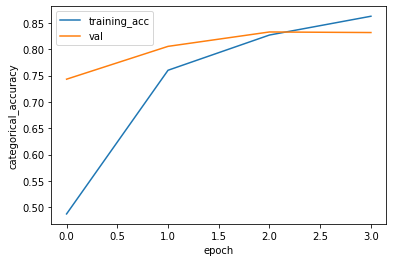

In [19]:
'''
#plotting the loss for training and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training','val'], loc='upper right')
plt.show()
'''
#plotting the accuracy for both, training and validation set. 
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('categorical_accuracy')
plt.legend(['training_acc','val'])
plt.show()

## second model

In [ ]:
#Model
#bert layers
input2_l        = Input(shape=(),dtype=tf.string,name='text_input')
preprocessed2_l = bert_preprocess(input2_l)
embedding2_l    = bert_encoder(preprocessed2_l)
#NN layers
drop2_l1        = Dropout(0.2)(embedding2_l['pooled_output'])

dense2_l1       = Dense(32,kernel_regularizer='l2',kernel_initializer='he_normal',activation='relu')(drop2_l1)
drop2_l2        = Dropout(0.3)(dense2_l1)
'''
dense2_l2       = Dense(64,kernel_regularizer='l2',kernel_initializer='he_normal',activation='relu')(drop2_l2)
drop2_l3        = Dropout(0.3)(dense2_l2)
dense2_l3       = Dense(32,kernel_regularizer='l2',kernel_initializer='he_normal',activation='relu')(drop2_l3)
drop2_l4        = Dropout(0.3)(dense2_l3)
dense2_l4       = Dense(16,kernel_regularizer='l2',kernel_initializer='he_normal',activation='relu')(drop2_l4)
drop2_l5        = Dropout(0.3)(dense2_l4)
'''
dense2_l_out    = Dense(5,activation='softmax',name='output')(drop2_l2)

model2 = tf.keras.Model(inputs=[input2_l],outputs=[dense2_l_out])

model2.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer_12 (KerasLayer)    {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                               

In [ ]:
def scheduler(epoch,lr):
    return lr*tf.math.exp(-0.05)

call = [
        tf.keras.callbacks.LearningRateScheduler(scheduler),
        tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy",patience=1)
        ]
opt = tfa.optimizers.AdamW(learning_rate=2e-3,weight_decay=1e-3)
Metrics = [
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
]
model2.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=Metrics
)

In [ ]:
history2 = model2.fit(X,y,epochs=5, validation_split=0.25,batch_size=32,callbacks=call)

Epoch 1/5
965/965 [==============================] - 289s 296ms/step - loss: 1.6309 - precision_20: 0.2436 - recall_20: 6.1554e-04 - categorical_accuracy: 0.2726 - val_loss: 1.5575 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_categorical_accuracy: 0.3028 - lr: 0.0019
Epoch 2/5
965/965 [==============================] - 284s 294ms/step - loss: 1.5668 - precision_20: 0.4286 - recall_20: 9.7191e-05 - categorical_accuracy: 0.2849 - val_loss: 1.5534 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_categorical_accuracy: 0.3005 - lr: 0.0018


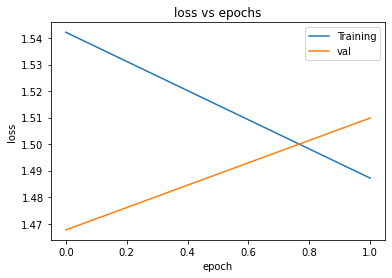

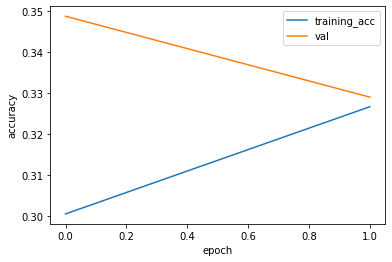

In [ ]:
#plotting the loss for training and validation set
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('loss vs epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training','val'], loc='upper right')
plt.show()
#plotting the accuracy for both, training and validation set. 
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training_acc','val'])
plt.show()

### Fine tuning the bert encoder layers

In [ ]:
model2.layers[2].trainable = True

In [ ]:
model2.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer_10 (KerasLayer)    {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                               

In [ ]:
def scheduler(epoch,lr):
    return lr*tf.math.exp(-0.05)

call2 = [
        tf.keras.callbacks.LearningRateScheduler(scheduler),
        tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy",patience=1)
        ]
opt2 = tfa.optimizers.AdamW(learning_rate=1e-5,weight_decay=1e-5)
Metrics = [
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
]
model2.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=Metrics
)

In [ ]:
fine_tune_epochs = 5
initial_epochs   = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(X,y,
                         epochs=total_epochs,
                         initial_epoch=history2.epoch[-1],
                         validation_split=0.25,batch_size=32,callbacks=call)

Epoch 3/8
965/965 [==============================] - 615s 622ms/step - loss: 1.5896 - precision_17: 0.1682 - recall_17: 5.8315e-04 - categorical_accuracy: 0.2605 - val_loss: 1.6020 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_categorical_accuracy: 0.2248 - lr: 8.1873e-05
Epoch 4/8
166/965 [====>.........................] - ETA: 7:17 - loss: 1.5830 - precision_17: 0.0000e+00 - recall_17: 0.0000e+00 - categorical_accuracy: 0.2581

KeyboardInterrupt: ignored

## Test-Data

In [20]:
df_test = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")

In [23]:
df_test['text'] = df_test['OriginalTweet'].apply(clean_text).apply(lambda x : x.lower())

In [28]:
df_test = pd.get_dummies(df_test,columns=['Sentiment']) 
y_true = df_test[['Sentiment_Extremely Negative', 'Sentiment_Extremely Positive',
       'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive']]

In [25]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock u...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby m...


In [27]:
y_pred = model.predict(df_test['text'])

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [61]:
rta = np.argmax(y_pred,axis=-1)

In [64]:
y_true_copy = np.argmax(y_true.to_numpy(),axis=-1)

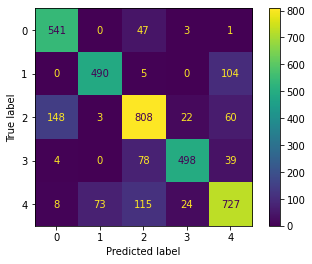

In [66]:
cm = confusion_matrix(y_true_copy, rta)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [67]:
from sklearn.metrics import f1_score
f1_score(y_true_copy, rta, average='weighted')

0.8068952668926409